# MMI Surrogate Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
import tidy3d.plugins.design as tdd

Constants used to create the 1x4 MMI `Simulation`

In [2]:
# material refractive indices
n_si = 3.48
n_gan = 2.305
n_sio2 = 1.444

# define media
si = td.Medium(permittivity=n_si**2)
gan = td.Medium(permittivity=n_gan**2)
sio2 = td.Medium(permittivity=n_sio2**2)

W_MMI = 5  # width of the MMI section
L_MMI = 11.2  # length of the MMI section
g1 = 0.9  # gap between the output waveguides
W1 = 0.4  # width of the waveguide
W2 = 0.8  # width of the tapper
L1 = 2  # length of the input tapper
L2 = 5  # length of the output tapper
H_Si = 0.3  # thickness of the Si layer
H_GaN = 0.1  # thickness of the GaN layer
g3 = (W2 - W1) / 2  # auxilary parameter defined for easier geometry building
g2 = g1 - 2 * g3  # gap between the output tapers
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

# buffer spacings in the x and y directions.
buffer_x = 1
buffer_y = 1.5

Build the MMI `Simulation` from the width and length of the body of the MMI

In [3]:
# define a function that takes the geometric parameters as input arguments and return a Simulation object
def make_sim(L_MMI, W_MMI):
    # the whole device is defined as a PolySlab with vertices given by the following
    vertices = np.array(
        [
            (-W1 / 2, -100),
            (-W1 / 2, 0),
            (-W2 / 2, L1),
            (-W_MMI / 2, L1),
            (-W_MMI / 2, L1 + L_MMI),
            (-g2 / 2 - W2 - g2 - 2 * g3 - W1, L1 + L_MMI),
            (-g2 / 2 - W2 - g2 - g3 - W1, L1 + L_MMI + L2),
            (-g2 / 2 - W2 - g2 - g3 - W1, 100),
            (-g2 / 2 - W2 - g2 - g3, 100),
            (-g2 / 2 - W2 - g2 - g3, L1 + L_MMI + L2),
            (-g2 / 2 - W2 - g2, L1 + L_MMI),
            (-g2 / 2 - W2, L1 + L_MMI),
            (-g1 / 2 - W1, L1 + L_MMI + L2),
            (-g1 / 2 - W1, 100),
            (-g1 / 2, 100),
            (-g1 / 2, L1 + L_MMI + L2),
            (-g2 / 2, L1 + L_MMI),
            (g2 / 2, L1 + L_MMI),
            (g1 / 2, L1 + L_MMI + L2),
            (g1 / 2, 100),
            (g1 / 2 + W1, 100),
            (g1 / 2 + W1, L1 + L_MMI + L2),
            (g2 / 2 + W2, L1 + L_MMI),
            (g2 / 2 + W2 + g2, L1 + L_MMI),
            (g2 / 2 + W2 + g2 + g3, L1 + L_MMI + L2),
            (g1 / 2 + W1 + g1, 100),
            (g1 / 2 + W1 + g1 + W1, 100),
            (g2 / 2 + W2 + g2 + g3 + W1, L1 + L_MMI + L2),
            (g2 / 2 + W2 + g2 + 2 * g3 + W1, L1 + L_MMI),
            (W_MMI / 2, L1 + L_MMI),
            (W_MMI / 2, L1),
            (W2 / 2, L1),
            (W1 / 2, 0),
            (W1 / 2, -100),
        ]
    )

    mmi_layer1 = td.Structure(
        geometry=td.PolySlab(
            vertices=vertices,
            axis=2,
            slab_bounds=(-H_Si - 0.5 * H_GaN, H_Si + 0.5 * H_GaN),
        ),
        medium=si,
    )
    mmi_layer2 = td.Structure(
        geometry=td.PolySlab(
            vertices=vertices, axis=2, slab_bounds=(-0.5 * H_GaN, 0.5 * H_GaN)
        ),
        medium=gan,
    )

    # simulation domain size
    Lx = W_MMI + 2 * buffer_x
    Ly = L1 + L_MMI + L2 + 2 * buffer_y
    Lz = 5 * (H_GaN * 2 + H_Si)
    sim_size = (Lx, Ly, Lz)

    mode_spec = td.ModeSpec(num_modes=2, target_neff=n_si)

    # add a mode source for excitation
    mode_source = td.ModeSource(
        center=(0, -buffer_y / 2, 0),
        size=(5 * W1, 0, Lz),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
        num_freqs=5,
    )

    # add two flux monitors to monitor the transmission power at output waveguides
    flux_monitor1 = td.FluxMonitor(
        center=((g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        name="flux1",
    )

    flux_monitor2 = td.FluxMonitor(
        center=(3 * (g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        name="flux2",
    )

    # add two mode monitors to monitor the mode profiles at output waveguides
    mode_monitor1 = td.ModeMonitor(
        center=((g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode1",
    )

    mode_monitor2 = td.ModeMonitor(
        center=(3 * (g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode2",
    )

    # Commented out to make sim cheaper
    # add a field monitor to monitor the field distribution
    # field_monitor = td.FieldMonitor(
    #     center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    # )

    sim = td.Simulation(
        center=(0, Ly / 2 - buffer_y, 0),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=td.C_0 / freq0),
        structures=[mmi_layer1, mmi_layer2],
        sources=[mode_source],
        monitors=[
            # field_monitor,
            flux_monitor1,
            flux_monitor2,
            mode_monitor1,
            mode_monitor2,
        ],
        run_time=5e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
        symmetry=(1, 0, -1),
    )
    return sim

Check the `Simulation` geometry by plotting the shape

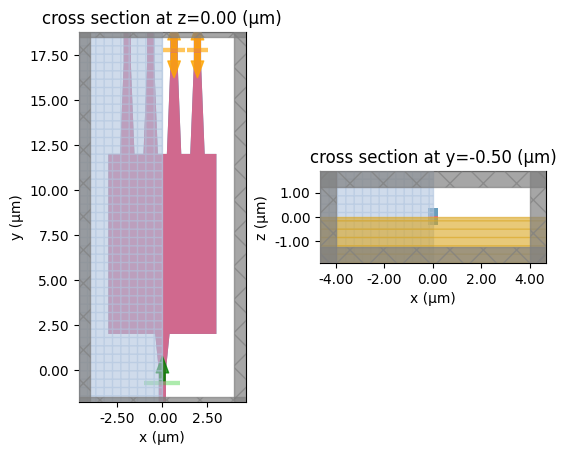

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)
sim = make_sim(10, 6)
sim.plot(z=0, ax=ax1)
sim.plot(y=-buffer_y / 3, ax=ax2)
plt.show()

Define a small `fn_post` function to extract the flux of the inner and outer output ports

In [5]:
def fn_post(sim_data):
    T1 = sim_data["flux1"].flux
    T2 = sim_data["flux2"].flux
    return {"T1": T1, "T2": T2}

Use a Monte Carlo sample to create an initial dataset

In [6]:
method = tdd.MethodMonteCarlo(
    num_points=100,
    seed=2,
)

l_param = tdd.ParameterFloat(name="L_MMI", span=(6, 16))
w_param = tdd.ParameterFloat(name="W_MMI", span=(5, 10))
parameters = [l_param, w_param]

output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mmi/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="mmi_2",
    folder_name="MMIV2",
    path_dir=output_dir,
)


Run the sampler

In [7]:
results = design_space.run(make_sim, fn_post, verbose=False)
df = results.to_dataframe()

17:16:50 BST WARNING: Simulation final field decay value of 2.24e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:55 BST WARNING: Simulation final field decay value of 2.94e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:56 BST WARNING: Simulation final field decay value of 3.71e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.11e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:57 BST WARNING: Simulation final field decay value of 3.12e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.05e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:58 BST WARNING: Simulation final field decay value of 2.08e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:03 BST WARNING: Simulation final field decay value of 2.82e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:05 BST WARNING: Simulation final field decay value of 1.79e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:08 BST WARNING: Simulation final field decay value of 1.59e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:09 BST WARNING: Simulation final field decay value of 1.43e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:10 BST WARNING: Simulation final field decay value of 1.12e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:11 BST WARNING: Simulation final field decay value of 1.01e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

In [7]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/surrogate_data/mmi/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

Plot distribution of width and length data in the training dataset

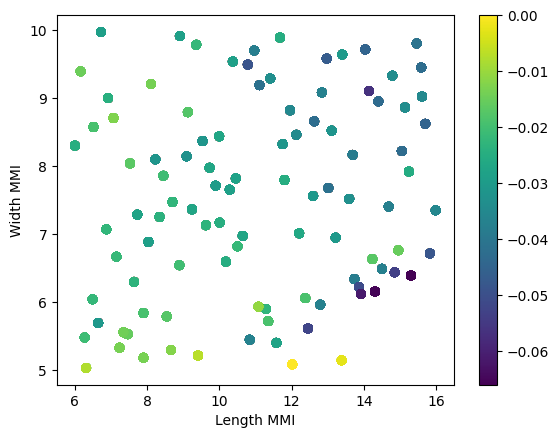

In [9]:
import matplotlib.colors as mcolors
# df.plot.scatter("W_MMI", "L_MMI")

fitness_val = -(abs(expanded_df["T1_cent"] - 0.25)**2 + abs(expanded_df["T2_cent"] - 0.25)**2)

norm = mcolors.Normalize(vmin=0, vmax=-0.06)

scatter = plt.scatter(expanded_df["L_MMI"], expanded_df["W_MMI"], c=fitness_val, norm=norm)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(scatter)
plt.show()

## Surrogate

Get the label information from within the x_array stored in the results

In [8]:
expanded_df = df.copy()

# Get T1 and T2 central freq values
expanded_df["T1_cent"] = expanded_df["T1"].apply(lambda x: float(x[int(len(expanded_df["T1"]) / 2)]))
expanded_df["T2_cent"] = expanded_df["T2"].apply(lambda x: float(x[int(len(expanded_df["T2"]) / 2)]))

# Change T1 and T2 to linear fake values 
# print("SANITY CHECK FOR TRANSMISSION")
# expanded_df["T1"] = expanded_df["T1"].apply(lambda x: x.copy(data=np.linspace(x[50] - 0.05, x[50] + 0.05, 101)))
# expanded_df["T2"] = expanded_df["T2"].apply(lambda x: x.copy(data=np.linspace(x[50] - 0.05, x[50] + 0.05, 101)))

# Change to all the same value
# expanded_df["T1"] = expanded_df["T1"].apply(lambda x: x.copy(data=np.full_like(x.data, x[50])))
# expanded_df["T2"] = expanded_df["T2"].apply(lambda x: x.copy(data=np.full_like(x.data, x[50])))


# Expand the array by each frequency value
expanded_df = expanded_df.explode(["T1", "T2"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["T1"].apply(lambda x: float(x.f))
expanded_df["T2"] = expanded_df["T2"].apply(lambda x: float(x))
expanded_df["T1"] = expanded_df["T1"].apply(lambda x: float(x))

# Cut the size down to test with less data
# expanded_df = expanded_df.iloc[:1010]

In [10]:
# TESTING
# Build effective L and W values based on freq
expanded_df["L_eff"] = expanded_df["freq"] / freq0 * expanded_df["L_MMI"]
expanded_df["W_eff"] = expanded_df["freq"] / freq0 * expanded_df["W_MMI"]

Define an AI model that will be trained on data stored in a `pandas.DataFrame`

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mmi"
data_dir = ["/home/matt/Documents/Flexcompute/surrogate_data/mmi/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 256
epochs = 100

trial_count = 40

model = AI_Model(output_dir, data_dir, seed=2)

model.load_data_from_df(
    df=expanded_df,
    label_names=["T1", "T2"],
    feature_names=["L_MMI", "W_MMI", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True,
    scale_inputs=True
)

# model.load_data_from_df(
#     df=expanded_df,
#     label_names=["T1", "T2"],
#     feature_names=["L_MMI", "W_MMI", "freq"],
#     test_percentage=test_percentage,
#     valid_percentage=valid_percentage,
#     batch_size=batch_size,
#     individual_feature_scaling=True
# )

loss_fn = nn.MSELoss()


Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


Define a Pytorch model that can be used for training. Also works with model optimization

In [10]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 2))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Train a model based on arbitrary hyperparameters

Using existing directory at Model1


  1%|          | 1/100 [00:00<00:12,  7.72it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2


  5%|▌         | 5/100 [00:00<00:04, 23.07it/s]

Best State Updated. Epoch: 3
Best State Updated. Epoch: 4
Best State Updated. Epoch: 5
Best State Updated. Epoch: 6
Best State Updated. Epoch: 7


  9%|▉         | 9/100 [00:00<00:03, 28.32it/s]

Best State Updated. Epoch: 8
Best State Updated. Epoch: 9
Best State Updated. Epoch: 10


 13%|█▎        | 13/100 [00:00<00:02, 30.14it/s]

Best State Updated. Epoch: 11
Best State Updated. Epoch: 12
Best State Updated. Epoch: 13


 17%|█▋        | 17/100 [00:00<00:02, 29.10it/s]

Best State Updated. Epoch: 14
Best State Updated. Epoch: 15
Best State Updated. Epoch: 16


 21%|██        | 21/100 [00:00<00:02, 30.81it/s]

Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 23


 25%|██▌       | 25/100 [00:00<00:02, 31.67it/s]

Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26


 29%|██▉       | 29/100 [00:01<00:02, 29.77it/s]

Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29


 33%|███▎      | 33/100 [00:01<00:02, 29.76it/s]

Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32
Best State Updated. Epoch: 33


 37%|███▋      | 37/100 [00:01<00:02, 25.41it/s]

Best State Updated. Epoch: 34
Best State Updated. Epoch: 35
Best State Updated. Epoch: 36


 41%|████      | 41/100 [00:01<00:02, 27.52it/s]

Best State Updated. Epoch: 37
Best State Updated. Epoch: 38
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40


 44%|████▍     | 44/100 [00:01<00:01, 28.01it/s]

Best State Updated. Epoch: 41
Best State Updated. Epoch: 43


 48%|████▊     | 48/100 [00:01<00:01, 29.64it/s]

Best State Updated. Epoch: 44
Best State Updated. Epoch: 46
Best State Updated. Epoch: 47
Best State Updated. Epoch: 48
Best State Updated. Epoch: 50


 52%|█████▏    | 52/100 [00:01<00:01, 29.46it/s]

Best State Updated. Epoch: 51
Best State Updated. Epoch: 52
Best State Updated. Epoch: 53
Best State Updated. Epoch: 54


 56%|█████▌    | 56/100 [00:01<00:01, 30.47it/s]

Best State Updated. Epoch: 55
Best State Updated. Epoch: 56
Best State Updated. Epoch: 57


 60%|██████    | 60/100 [00:02<00:01, 31.33it/s]

Best State Updated. Epoch: 58
Best State Updated. Epoch: 59
Best State Updated. Epoch: 60
Best State Updated. Epoch: 61


 64%|██████▍   | 64/100 [00:02<00:01, 32.26it/s]

Best State Updated. Epoch: 62
Best State Updated. Epoch: 63
Best State Updated. Epoch: 64


 68%|██████▊   | 68/100 [00:02<00:00, 32.54it/s]

Best State Updated. Epoch: 65
Best State Updated. Epoch: 66
Best State Updated. Epoch: 67
Best State Updated. Epoch: 69
Best State Updated. Epoch: 70


 76%|███████▌  | 76/100 [00:02<00:00, 31.06it/s]

Best State Updated. Epoch: 72
Best State Updated. Epoch: 74
Best State Updated. Epoch: 75
Best State Updated. Epoch: 76
Best State Updated. Epoch: 77
Best State Updated. Epoch: 78


 80%|████████  | 80/100 [00:02<00:00, 30.85it/s]

Best State Updated. Epoch: 79
Best State Updated. Epoch: 80


 84%|████████▍ | 84/100 [00:02<00:00, 31.30it/s]

Best State Updated. Epoch: 83
Best State Updated. Epoch: 85


 88%|████████▊ | 88/100 [00:03<00:00, 27.08it/s]

Best State Updated. Epoch: 86
Best State Updated. Epoch: 87


 91%|█████████ | 91/100 [00:03<00:00, 26.18it/s]

Best State Updated. Epoch: 88
Best State Updated. Epoch: 89
Best State Updated. Epoch: 91


 95%|█████████▌| 95/100 [00:03<00:00, 28.24it/s]

Best State Updated. Epoch: 92
Best State Updated. Epoch: 93
Best State Updated. Epoch: 94


 98%|█████████▊| 98/100 [00:03<00:00, 28.51it/s]

Best State Updated. Epoch: 97
Best State Updated. Epoch: 98
Best State Updated. Epoch: 99


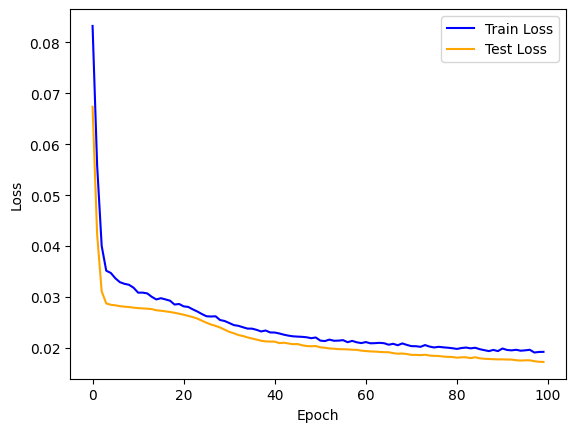

100%|██████████| 100/100 [00:03<00:00, 28.63it/s]


 Best Test Loss: 0.017235232517123222
RMSE: 0.029873
MAE: 0.022987
Fold: 0


100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


 Best Test Loss: 0.01385454647243023
RMSE: 0.026908
MAE: 0.021328
Fold: 1


100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


 Best Test Loss: 0.013969416730105877
RMSE: 0.02708
MAE: 0.021147
Fold: 2


100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


 Best Test Loss: 0.014539106748998165
RMSE: 0.027603
MAE: 0.021786
Fold: 3


100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


 Best Test Loss: 0.014770686626434326
RMSE: 0.027794
MAE: 0.021816
Fold: 4


100%|██████████| 100/100 [00:04<00:00, 24.46it/s]

 Best Test Loss: 0.014552745036780834
RMSE: 0.027629
MAE: 0.021675
[0.026908, 0.02708, 0.027603, 0.027794, 0.027629]
Mean RMSE: 0.027 +/- 0.000


[0.027402799999999998, 0.0003375842686856122]

In [11]:
# Create single model
network = VariableANN(3, [4, 4, 4], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")


In [12]:
# TESTING
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")
valid_rmse, _, valid_predictions = model.validate_model(trained_net, "valid")

print(model.train_labels[1].mean())

RMSE: 0.029873
MAE: 0.022987
RMSE: 0.029522
MAE: 0.022681
0.1094048023223877


Alternatively, sweep through the model design space and find the optimum model architecture

In [13]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 3},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

model.k_fold_training(
    num_folds=5,
    network_model=best_network,
    optimizer=best_optimizer,
    loss_function=loss_fn,
    epochs=1000,
    individual_feature_scaling=True,
    batch_size=batch_size
)

# trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 1000, plot_output=True)

[I 2024-09-18 14:12:21,165] A new study created in memory with name: no-name-329ccb18-1e5b-4df3-968c-3dd034a84553


Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.08it/s]
[I 2024-09-18 14:12:24,745] Trial 0 finished with value: 0.025996 and parameters: {'dropout': 0.2, 'neurons0': 16, 'neurons1': 144, 'neurons2': 112, 'neurons3': 112, 'lr': 0.00020957490791939475, 'weight_decay': 2.56623998836808e-05}. Best is trial 0 with value: 0.025996.


 Best Test Loss: 0.012926447205245495
RMSE: 0.025996
MAE: 0.020431
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.92it/s]
[I 2024-09-18 14:12:28,211] Trial 1 finished with value: 0.032972 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 80, 'neurons1': 80, 'neurons2': 160, 'neurons3': 144, 'lr': 3.453979704854047e-05, 'weight_decay': 0.00010645259250245113}. Best is trial 0 with value: 0.025996.


 Best Test Loss: 0.020492803305387497
RMSE: 0.032972
MAE: 0.02501
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]
[I 2024-09-18 14:12:31,814] Trial 2 finished with value: 0.028484 and parameters: {'dropout': 0.1, 'neurons0': 208, 'neurons1': 224, 'neurons2': 128, 'neurons3': 224, 'lr': 2.0824851253449582e-05, 'weight_decay': 0.0001024453334191056}. Best is trial 0 with value: 0.025996.


 Best Test Loss: 0.015527835115790367
RMSE: 0.028484
MAE: 0.021517
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.27it/s]
[I 2024-09-18 14:12:35,240] Trial 3 finished with value: 0.026657 and parameters: {'dropout': 0.0, 'neurons0': 112, 'neurons1': 32, 'neurons2': 48, 'neurons3': 160, 'lr': 8.017666774803345e-05, 'weight_decay': 1.6364071508075995e-05}. Best is trial 0 with value: 0.025996.


 Best Test Loss: 0.013553036376833916
RMSE: 0.026657
MAE: 0.020529
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.43it/s]
[I 2024-09-18 14:12:38,767] Trial 4 finished with value: 0.019664 and parameters: {'dropout': 0.1, 'neurons0': 96, 'neurons1': 128, 'neurons2': 64, 'neurons3': 176, 'lr': 0.0008556168765786835, 'weight_decay': 0.00010244091290412624}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.007364881690591574
RMSE: 0.019664
MAE: 0.01592
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.72it/s]
[I 2024-09-18 14:12:42,257] Trial 5 finished with value: 0.039115 and parameters: {'dropout': 0.2, 'neurons0': 208, 'neurons1': 160, 'neurons2': 48, 'neurons3': 192, 'lr': 0.0721446814835575, 'weight_decay': 0.00010000385053531142}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.02859480120241642
RMSE: 0.039115
MAE: 0.030168
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.79it/s]
[I 2024-09-18 14:12:45,865] Trial 6 finished with value: 0.026182 and parameters: {'dropout': 0.45, 'neurons0': 96, 'neurons1': 160, 'neurons2': 112, 'neurons3': 112, 'lr': 0.012771348031164653, 'weight_decay': 0.00011781710498405417}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.012225405313074589
RMSE: 0.026182
MAE: 0.020473
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.87it/s]
[I 2024-09-18 14:12:49,341] Trial 7 finished with value: 0.027922 and parameters: {'dropout': 0.5, 'neurons0': 144, 'neurons1': 32, 'neurons2': 96, 'neurons3': 224, 'lr': 0.00042179378105206954, 'weight_decay': 1.1334561723036805e-05}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.014778204262256622
RMSE: 0.027922
MAE: 0.022073
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.69it/s]
[I 2024-09-18 14:12:52,963] Trial 8 finished with value: 0.020853 and parameters: {'dropout': 0.1, 'neurons0': 32, 'neurons1': 256, 'neurons2': 256, 'neurons3': 208, 'lr': 0.0025542798985646654, 'weight_decay': 0.00033878152677157994}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.008296545594930649
RMSE: 0.020853
MAE: 0.016791
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.44it/s]
[I 2024-09-18 14:12:56,488] Trial 9 finished with value: 0.022868 and parameters: {'dropout': 0.05, 'neurons0': 80, 'neurons1': 144, 'neurons2': 96, 'neurons3': 16, 'lr': 0.08562760193073449, 'weight_decay': 7.633256192478052e-05}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.010104650631546974
RMSE: 0.022868
MAE: 0.018439
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.33it/s]
[I 2024-09-18 14:13:00,044] Trial 10 finished with value: 0.030599 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 160, 'neurons1': 96, 'neurons2': 16, 'neurons3': 64, 'lr': 0.0023435510642152513, 'weight_decay': 0.0007498580827111435}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.017928598448634148
RMSE: 0.030599
MAE: 0.023021
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.30it/s]
[I 2024-09-18 14:13:03,475] Trial 11 finished with value: 0.02198 and parameters: {'dropout': 0.1, 'neurons0': 16, 'neurons1': 256, 'neurons2': 256, 'neurons3': 256, 'lr': 0.00200739364972314, 'weight_decay': 0.0004249504656179168}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.009318917989730835
RMSE: 0.02198
MAE: 0.017719
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.19it/s]
[I 2024-09-18 14:13:06,921] Trial 12 finished with value: 0.021961 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 48, 'neurons1': 208, 'neurons2': 240, 'neurons3': 192, 'lr': 0.006227221349614544, 'weight_decay': 0.0002819347175541913}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.008547695353627205
RMSE: 0.021961
MAE: 0.017761
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.98it/s]
[I 2024-09-18 14:13:10,391] Trial 13 finished with value: 0.01984 and parameters: {'dropout': 0.0, 'neurons0': 48, 'neurons1': 96, 'neurons2': 192, 'neurons3': 176, 'lr': 0.0005593379823293206, 'weight_decay': 0.000250281943316076}. Best is trial 4 with value: 0.019664.


 Best Test Loss: 0.007643466349691153
RMSE: 0.01984
MAE: 0.016002
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.19it/s]
[I 2024-09-18 14:13:13,836] Trial 14 finished with value: 0.018716 and parameters: {'dropout': 0.0, 'neurons0': 64, 'neurons1': 96, 'neurons2': 192, 'neurons3': 160, 'lr': 0.0005484417682747005, 'weight_decay': 4.233047899241224e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.006818427704274654
RMSE: 0.018716
MAE: 0.015141
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.41it/s]
[I 2024-09-18 14:13:17,143] Trial 15 finished with value: 0.01991 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 64, 'neurons2': 192, 'neurons3': 112, 'lr': 0.00015959053774279068, 'weight_decay': 4.937216228436726e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.007678763009607792
RMSE: 0.01991
MAE: 0.01599
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.91it/s]
[I 2024-09-18 14:13:20,745] Trial 16 finished with value: 0.023206 and parameters: {'dropout': 0.25, 'neurons0': 128, 'neurons1': 112, 'neurons2': 176, 'neurons3': 80, 'lr': 0.016138773159690527, 'weight_decay': 3.394293797577441e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.009219411760568619
RMSE: 0.023206
MAE: 0.01836
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.39it/s]
[I 2024-09-18 14:13:24,168] Trial 17 finished with value: 0.019139 and parameters: {'dropout': 0.05, 'neurons0': 64, 'neurons1': 176, 'neurons2': 224, 'neurons3': 144, 'lr': 0.0008952256828502206, 'weight_decay': 5.193861315361771e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.007091013714671135
RMSE: 0.019139
MAE: 0.01549
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.25it/s]
[I 2024-09-18 14:13:27,607] Trial 18 finished with value: 0.042126 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 64, 'neurons1': 208, 'neurons2': 224, 'neurons3': 144, 'lr': 1.126382991616871e-05, 'weight_decay': 4.6380425054676704e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.0317152738571167
RMSE: 0.042126
MAE: 0.033603
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.14it/s]
[I 2024-09-18 14:13:31,181] Trial 19 finished with value: 0.021123 and parameters: {'dropout': 0.05, 'neurons0': 176, 'neurons1': 176, 'neurons2': 208, 'neurons3': 64, 'lr': 0.0001077521181958582, 'weight_decay': 2.1441539628618083e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.008307981304824352
RMSE: 0.021123
MAE: 0.01698
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.51it/s]
[I 2024-09-18 14:13:34,836] Trial 20 finished with value: 0.021938 and parameters: {'dropout': 0.2, 'neurons0': 64, 'neurons1': 64, 'neurons2': 160, 'neurons3': 128, 'lr': 0.00032980742064367164, 'weight_decay': 5.862555584366668e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.00884915515780449
RMSE: 0.021938
MAE: 0.017654
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.48it/s]
[I 2024-09-18 14:13:38,247] Trial 21 finished with value: 0.019676 and parameters: {'dropout': 0.05, 'neurons0': 112, 'neurons1': 128, 'neurons2': 224, 'neurons3': 160, 'lr': 0.0010269790367666996, 'weight_decay': 0.0001707468123728392}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.00750600453466177
RMSE: 0.019676
MAE: 0.015917
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.93it/s]
[I 2024-09-18 14:13:41,724] Trial 22 finished with value: 0.019335 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 96, 'neurons1': 192, 'neurons2': 64, 'neurons3': 176, 'lr': 0.0010646223865725907, 'weight_decay': 3.510119965916949e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.007218081969767809
RMSE: 0.019335
MAE: 0.015673
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.33it/s]
[I 2024-09-18 14:13:45,276] Trial 23 finished with value: 0.019174 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 48, 'neurons1': 192, 'neurons2': 144, 'neurons3': 160, 'lr': 0.0013820346960942572, 'weight_decay': 3.1529951409484753e-05}. Best is trial 14 with value: 0.018716.


 Best Test Loss: 0.007011456415057182
RMSE: 0.019174
MAE: 0.015557
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.55it/s]
[I 2024-09-18 14:13:48,680] Trial 24 finished with value: 0.018485 and parameters: {'dropout': 0.05, 'neurons0': 48, 'neurons1': 224, 'neurons2': 144, 'neurons3': 96, 'lr': 0.00607200834545081, 'weight_decay': 1.6192125382976442e-05}. Best is trial 24 with value: 0.018485.


 Best Test Loss: 0.0066587780602276325
RMSE: 0.018485
MAE: 0.014963
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.91it/s]
[I 2024-09-18 14:13:51,939] Trial 25 finished with value: 0.018364 and parameters: {'dropout': 0.0, 'neurons0': 32, 'neurons1': 240, 'neurons2': 192, 'neurons3': 80, 'lr': 0.005498197348611598, 'weight_decay': 1.5316627908459823e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006545103155076504
RMSE: 0.018364
MAE: 0.014769
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.33it/s]
[I 2024-09-18 14:13:55,369] Trial 26 finished with value: 0.018833 and parameters: {'dropout': 0.0, 'neurons0': 16, 'neurons1': 240, 'neurons2': 176, 'neurons3': 32, 'lr': 0.005920426236691699, 'weight_decay': 1.276010807463955e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006847998593002558
RMSE: 0.018833
MAE: 0.015154
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.10it/s]
[I 2024-09-18 14:13:58,711] Trial 27 finished with value: 0.019783 and parameters: {'dropout': 0.0, 'neurons0': 32, 'neurons1': 224, 'neurons2': 144, 'neurons3': 80, 'lr': 0.033965354597456365, 'weight_decay': 1.7606434818508074e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.0074279760010540485
RMSE: 0.019783
MAE: 0.016012
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.83it/s]
[I 2024-09-18 14:14:02,199] Trial 28 finished with value: 0.018448 and parameters: {'dropout': 0.05, 'neurons0': 32, 'neurons1': 240, 'neurons2': 192, 'neurons3': 96, 'lr': 0.0049286229350376295, 'weight_decay': 1.0687755284376257e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006598781794309616
RMSE: 0.018448
MAE: 0.014906
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.23it/s]
[I 2024-09-18 14:14:05,761] Trial 29 finished with value: 0.019061 and parameters: {'dropout': 0.05, 'neurons0': 16, 'neurons1': 240, 'neurons2': 128, 'neurons3': 96, 'lr': 0.0050268431383161056, 'weight_decay': 1.035113656205318e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006726762279868126
RMSE: 0.019061
MAE: 0.01541
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.66it/s]
[I 2024-09-18 14:14:09,406] Trial 30 finished with value: 0.020742 and parameters: {'dropout': 0.2, 'neurons0': 32, 'neurons1': 224, 'neurons2': 160, 'neurons3': 48, 'lr': 0.015312937453930097, 'weight_decay': 2.3914723266120608e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.008037733845412731
RMSE: 0.020742
MAE: 0.016803
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.54it/s]
[I 2024-09-18 14:14:12,929] Trial 31 finished with value: 0.01854 and parameters: {'dropout': 0.05, 'neurons0': 48, 'neurons1': 256, 'neurons2': 192, 'neurons3': 96, 'lr': 0.0038154320388002964, 'weight_decay': 1.4909411628176173e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006629974115639925
RMSE: 0.01854
MAE: 0.014958
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.50it/s]
[I 2024-09-18 14:14:16,339] Trial 32 finished with value: 0.019063 and parameters: {'dropout': 0.1, 'neurons0': 32, 'neurons1': 256, 'neurons2': 208, 'neurons3': 96, 'lr': 0.003920134074641705, 'weight_decay': 1.466356257062876e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.00698845274746418
RMSE: 0.019063
MAE: 0.015492
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.10it/s]
[I 2024-09-18 14:14:19,796] Trial 33 finished with value: 0.018803 and parameters: {'dropout': 0.05, 'neurons0': 80, 'neurons1': 240, 'neurons2': 176, 'neurons3': 96, 'lr': 0.009654298425826147, 'weight_decay': 2.0734510705783783e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006861562374979258
RMSE: 0.018803
MAE: 0.015225
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.30it/s]
[I 2024-09-18 14:14:23,483] Trial 34 finished with value: 0.021422 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 48, 'neurons1': 208, 'neurons2': 208, 'neurons3': 64, 'lr': 0.027515552134346772, 'weight_decay': 1.0191704316617021e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.008645681664347649
RMSE: 0.021422
MAE: 0.017362
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.30it/s]
[I 2024-09-18 14:14:26,916] Trial 35 finished with value: 0.021519 and parameters: {'dropout': 0.1, 'neurons0': 16, 'neurons1': 240, 'neurons2': 160, 'neurons3': 128, 'lr': 0.027963984999112537, 'weight_decay': 1.7100319595540325e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.007916390895843506
RMSE: 0.021519
MAE: 0.017459
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.35it/s]
[I 2024-09-18 14:14:30,344] Trial 36 finished with value: 0.019031 and parameters: {'dropout': 0.25, 'neurons0': 80, 'neurons1': 224, 'neurons2': 128, 'neurons3': 112, 'lr': 0.0035540461044868553, 'weight_decay': 1.325542310437955e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.006982685998082161
RMSE: 0.019031
MAE: 0.015413
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.35it/s]
[I 2024-09-18 14:14:33,892] Trial 37 finished with value: 0.022709 and parameters: {'dropout': 0.05, 'neurons0': 32, 'neurons1': 256, 'neurons2': 176, 'neurons3': 80, 'lr': 0.04894850459220828, 'weight_decay': 2.75548947325693e-05}. Best is trial 25 with value: 0.018364.


 Best Test Loss: 0.008799980394542217
RMSE: 0.022709
MAE: 0.018363
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.16it/s]
[I 2024-09-18 14:14:37,341] Trial 38 finished with value: 0.018218 and parameters: {'dropout': 0.0, 'neurons0': 112, 'neurons1': 192, 'neurons2': 240, 'neurons3': 48, 'lr': 0.008587923524541945, 'weight_decay': 1.796322757538671e-05}. Best is trial 38 with value: 0.018218.


 Best Test Loss: 0.006478691939264536
RMSE: 0.018218
MAE: 0.014702
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.50it/s]
[I 2024-09-18 14:14:40,752] Trial 39 finished with value: 0.018668 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 192, 'neurons2': 240, 'neurons3': 48, 'lr': 0.008421555382741027, 'weight_decay': 1.824167842294368e-05}. Best is trial 38 with value: 0.018218.


 Best Test Loss: 0.0066652619279921055
RMSE: 0.018668
MAE: 0.01504
Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  0
  Number of complete trials:  40
Best trial:
  Value:  0.018218
  Params: 
    dropout: 0.0
    neurons0: 112
    neurons1: 192
    neurons2: 240
    neurons3: 48
    lr: 0.008587923524541945
    weight_decay: 1.796322757538671e-05
Fold: 0


100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s]


 Best Test Loss: 0.007294579409062862
RMSE: 0.019633
MAE: 0.015848
Fold: 1


100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]


 Best Test Loss: 0.006999020930379629
RMSE: 0.02016
MAE: 0.01608
Fold: 2


100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


 Best Test Loss: 0.00715690478682518
RMSE: 0.020106
MAE: 0.016183
Fold: 3


100%|██████████| 1000/1000 [00:42<00:00, 23.78it/s]


 Best Test Loss: 0.007072282489389181
RMSE: 0.019812
MAE: 0.016088
Fold: 4


100%|██████████| 1000/1000 [00:42<00:00, 23.81it/s]

 Best Test Loss: 0.007211118470877409
RMSE: 0.020181
MAE: 0.016277
[0.019633, 0.02016, 0.020106, 0.019812, 0.020181]
Mean RMSE: 0.020 +/- 0.000


[0.0199784, 0.0002134948387572869]

RMSE: 0.014194
MAE: 0.011154


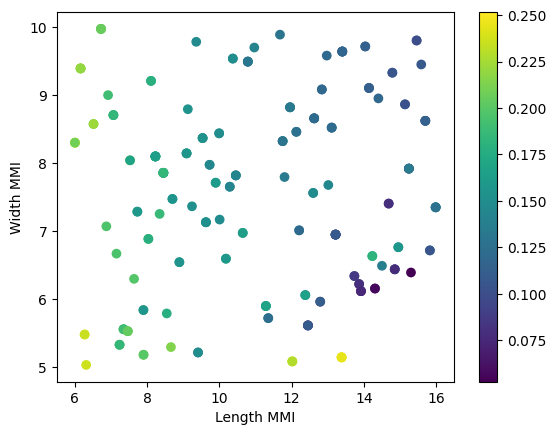

In [15]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

features = [x for x, _ in model.test_loaded]
combined = torch.concat(features)
l = [model.feature_scaler[0].inverse_transform(row[0].reshape(1, -1)) for row in combined]
w = [model.feature_scaler[1].inverse_transform(row[1].reshape(1, -1)) for row in combined]

T1_val = [row[0] for row in test_predictions]

scatter = plt.scatter(l, w, c=T1_val)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(scatter)
plt.show()

## Optimizing with Predictions

Create a single function `run_fn` that takes suggested values and makes a prediction of transmition. Take the mean predicted value as an arbitrary loss function

In [16]:
def run_fn(L_MMI, W_MMI, freq):

    
    feature_array = np.array((L_MMI, W_MMI, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)

    # return prediction[0]
    return -(abs(prediction[0] - 0.25)**2 + abs(prediction[1] - 0.25)**2)

# def run_fn(L_MMI, W_MMI, freq):
#     norm_freq = freq / freq0
#     L_eff = L_MMI * norm_freq
#     W_eff = W_MMI * norm_freq
    
#     feature_array = np.array((L_eff, W_eff))
#     feature_array = feature_array.reshape((1, -1))
#     prediction = model.make_prediction(trained_net, False, feature_array, 2)

#     # return prediction[0]
#     return -(abs(prediction[0] - 0.25)**2 + abs(prediction[1] - 0.25)**2)

Use Bayesian optimization evaluating the AI model to determine the best width and length parameters.

In [17]:
method = tdd.MethodBayOpt(
    initial_iter=500,
    n_iter=100,
    acq_func='ucb',
    kappa=10,
    xi=0.9,
    seed=1,
)

# l_param = tdd.ParameterFloat(name="L_MMI", span=(4, 24))
# w_param = tdd.ParameterFloat(name="W_MMI", span=(4.5, 16))
# freq = tdd.ParameterFloat(name="freq", span=(193414489032258.0, 193414489032258.0))
# predict_parameters = [l_param, w_param, freq]
predict_parameters = parameters + [tdd.ParameterFloat(name="freq", span=(193414489032258.0, 193414489032258.0))]

output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mmi/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=predict_parameters,
    task_name="mmi_predict_1",
    folder_name="MMIV1",
    path_dir=output_dir,
)

In [18]:
predict_results = design_space.run(run_fn, verbose=True)
predict_df = predict_results.to_dataframe()

14:03:37 BST Best Fit from Initial Solutions: -0.0                              
             

14:03:44 BST Latest Best Fit on Iter 10: -0.0                                   
             

14:04:31 BST Latest Best Fit on Iter 74: -0.0                                   
             

14:04:56 BST Best Result: -9.231250494012855e-06                                
             Best Parameters: L_MMI: 12.42416167298461 W_MMI: 5.019732777094195 
             freq: 193414489032258.0                                            
             

In [19]:
def pred(L_MMI, W_MMI, freq):
    
    feature_array = np.array((L_MMI, W_MMI, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)

    return prediction

a_prediction = pred(**predict_results.optimizer.max['params'])
print(a_prediction)

[0.24850480258464813, 0.24735507369041443]


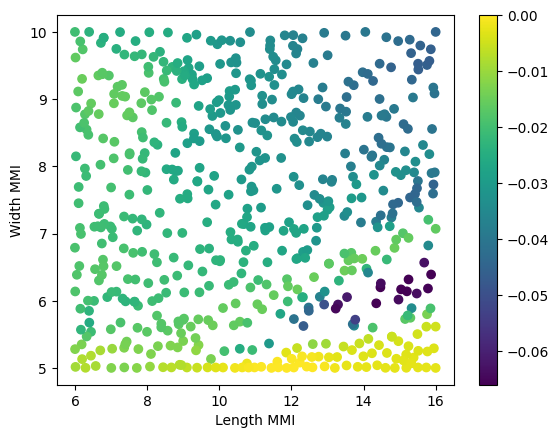

In [20]:
predict_scatter = plt.scatter(predict_df["L_MMI"], predict_df["W_MMI"], c=predict_df["output"], norm=norm)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(predict_scatter)
plt.show()

In [21]:
# sim = make_sim(L_MMI=predict_results.optimizer.max['params']["L_MMI"], W_MMI=predict_results.optimizer.max['params']["W_MMI"])
# sim_data = web.run(sim, task_name="best_predicted")

import tidy3d.web as web
import random

sample_count = 20

# Build a batch with the best result and a selection of other results
sims = {"best": make_sim(L_MMI=predict_results.optimizer.max['params']["L_MMI"], W_MMI=predict_results.optimizer.max['params']["W_MMI"])}
random_vals = random.sample(predict_results.optimizer.res, sample_count)
for i in range(sample_count):
    sims[i] = make_sim(L_MMI=random_vals[i]["params"]["L_MMI"], W_MMI=random_vals[i]["params"]["W_MMI"])

sim_data = web.Batch(simulations=sims, verbose=False).run()

In [22]:
difference = []
for key, res in sim_data.items():
    if key == "5":
        continue
    if key == "best":
        params = predict_results.optimizer.max["params"]
    else:
        params = random_vals[int(key)]["params"]
    
    prediction = pred(**params)

    T_dict = fn_post(res)
    t1_diff = abs(prediction[0] - float(T_dict['T1'][50]))
    t2_diff = abs(prediction[1] - float(T_dict['T2'][50]))
    difference.append(sum([t1_diff, t2_diff]))

mean_diff = sum(difference) / len(difference)
print(f"Mean Difference: {mean_diff}")

14:09:37 BST WARNING: Simulation final field decay value of 3.81e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.91e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Mean Difference: 0.023804688453674318
